# Problem Set5

### Question 0
First we import all the packages we need in whole PS.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import os
from itertools import combinations

Now we fit the model with the following code. we find that even we do not need to manupulate data to categorical since the ```OLS``` function will treat it as categorical automatically

In [2]:
file = 'tooth_growth.feather'
if os.path.exists(file):
    tg_data = pd.read_feather(file)
else: 
    tooth_growth = sm.datasets.get_rdataset('ToothGrowth')
    #print(tooth_growth.__doc__)
    tg_data = tooth_growth.data
    tg_data.to_feather(file)
tg_data['dose'] = pd.Categorical(tg_data['dose'])
tg_data['len'] = tg_data['len'].apply(np.log)
data = pd.get_dummies(tg_data,columns=['supp']).iloc[:,[0,1,3]]
model1 = sm.OLS.from_formula('len~dose*supp',data=tg_data).fit()
model2 = sm.OLS.from_formula('len~1',data=tg_data).fit()
model3 = sm.OLS.from_formula('len~dose*supp_VC',data=data).fit()
print(model1.summary())
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                    len   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     41.69
Date:                Fri, 05 Nov 2021   Prob (F-statistic):           2.34e-17
Time:                        13:14:41   Log-Likelihood:                 4.2612
No. Observations:                  60   AIC:                             3.478
Df Residuals:                      54   BIC:                             16.04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  2

We have the formula to calculate $R^2: R^2 = 1-\frac{\sum_{i=1}^n(Y_i - \hat{Y_i})^2}{\sum_{i=1}^n (Y_i - \bar{Y_i})^2}=1-\frac{RSS}{TSS}$. And we will use this formula to calculate. And the formula of $Adjust R^2$ is $1-\frac{(1-R^2)(N-1)}{N-p-1}$ where $N$ is the sample size and $p$ is the number of variables.

We use 2 different ways wo get $TSS$ in formula. First, when we do not have any variables, the result of linear model is the $\bar{Y_i}$. Hence the $TSS$ is the $RSS$ of model without any variable. Also, we can use the properites from the model to get $TSS$ directly. We use both method to get the same result.

In [3]:
ssr1 = model1.ssr
ssr2 = model2.ssr
R21 = 1-ssr1/ssr2
R22 = 1-ssr1/model1.centered_tss
print(R21,R22)
Adjust_R21 = 1-(59/54)*(1-R21)
Adjust_R22 = 1-(59/54)*(1-R22)
print(Adjust_R21,Adjust_R22)

0.7942457970936073 0.7942457970936073
0.7751944820096821 0.7751944820096821


We can see that we get the same result as the $R-squared$ And $Adj. R-squared$  which is 0.794 and 0.775 in the summary of model1 and model3. Also, we use the following code to calculate $RSS$ by ourselves to get the same answer.

In [4]:
y_hat = model1.fittedvalues
residual1 = y_hat-tg_data['len']
rss3 = np.sum(np.square(residual1))
y_hat = model2.fittedvalues
residual1 = y_hat-tg_data['len']
rss4 = np.sum(np.square(residual1))
R23 = 1-rss3/rss4
Adjust_R23 = 1-(59/54)*(1-R23)
print(R23,Adjust_R23)

0.7942457970936072 0.775194482009682


### Question 1
#### Part A
In this part, we will use ```OHX01TC``` as our target variable. First, we need to prepare the data.

In [5]:
data1 = pd.read_pickle('oral health dentition data.pickle')
data2 = pd.read_pickle('demographic data.pickle')
data = pd.merge(data1['Tooth_Count_01'],data2,how='left',on = 'UniqueID')

We cannot deal with the missing value in target variable. Hence we drop these data and let ```OHX01TC``` be a binary Y in order to use logitstic regression.

In [6]:
data.dropna(inplace=True,subset=['Tooth_Count_01'])
data['TC01'] = data['Tooth_Count_01'].apply(lambda x: 1 if x== 2 else 0)

Now our analysis will only focus on whose ```age``` is greater than 12. And in B-spline part, we will only use knots with age no less than 14.Also we fill all the ```NAN``` value to a new categorical ```missing values```. E.g we think missing values is also a value of variable.

In [7]:
data = data[data['age']>=12]
age = data['age'].unique()
total_age = list(age)
total_age = [x for x in total_age if x>=14]

In [8]:
data['education'] = data['education'].cat.add_categories('missing values')
data['marital_status']=data['marital_status'].cat.add_categories('missing values')
data['education'] = data['education'].fillna('missing values')
data['marital_status'] = data['marital_status'].fillna('missing values')

And our analysis will only focos on the knots selection with ```degree = 3```. We can know that we need to have 4 knots in total.

if we traverse all the subsets of 4 knots, we need to fit 67 choose 4 model. In my pc, it will take more than 15 hours to pick the model with minimal aic. Hence, Here, we use an idea similar to Coordinate descent. That is to say, we will pick knots one by one. And when we pick the first knot, we will traverse all the subsets of 1 knots to get the best model with 1 knot. And when we pick the second knot, we will traverse all the subsets of 2 knot containing the first knot. And for the third,fourth knot, we have the same idea.

In [9]:
result = []
while len(result) < 4:
    temp_result = 0
    min_aic = 1000000
    for i in total_age:
        poss_knots = result.copy()
        poss_knots.append(i)
        try:
            model = smf.logit('TC01~bs(age,knots=np.array(poss_knots))',data).fit()
            if model.aic < min_aic:
                min_aic = model.aic
                temp_result = i
        except:
            continue
    result.append(temp_result)
    total_age.remove(temp_result)

Optimization terminated successfully.
         Current function value: 0.458422
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.466762
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.462660
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.458841
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.465617
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.462387
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.468333
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.459740
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.464400
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.465232

Optimization terminated successfully.
         Current function value: 0.457906
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.457906
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.457908
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.457906
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.457903
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.457901
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.457883
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.457908
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.457906
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.457907
  

Optimization terminated successfully.
         Current function value: 0.457868
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.457874
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.457869
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.457871
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.457875
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.457859
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.457874
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.457872
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.457868
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.457875


Optimization terminated successfully.
         Current function value: 0.457764
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.457849
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.457850
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.457850
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.457850
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.457848
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.457849
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.457841
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.457850
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.457850
 

And we get the result, the best 4 knots we find is ```[25,79,78,77]``` with the minimal aic is 23188.868 

In [10]:
print(min_aic)
print(result)

23188.86848682841
[25, 79, 78, 77]


Now we consider how to add demograhic data into the model. First we prepare the data with possible variables to add.

In [11]:
all_col = list(data.columns)
delete_col = ['Tooth_Count_01','age','MEC weight','Interview weight','TC01']
for col in delete_col:
    all_col.remove(col)
all_col

['gender',
 'race',
 'education',
 'marital_status',
 'exam_status',
 'Pseudo-PSU',
 'Pseudo-Stratum',
 'cohort']

With only 8 possible variables, we can traverse all the subsets of variables to get the model with minimal aic. Here, we define a function ```choose_best_sub``` to get the best subsets and minimal aic.

In [12]:
formula_str = 'TC01~bs(age,knots=np.array(result)){}'
def choose_best_sub(col_list,data,min_aic_init=1000000):
    length = len(col_list)
    result_col = []
    best_formula = ""
    for i in range(length+1):
        i_combination = list(combinations(col_list,i))
        for poss_col in i_combination:
            format_str = ""
            for col in poss_col:
                format_str += "+"+col
            formula_temp = formula_str.format(format_str)
            try:
                model = smf.logit(formula_temp,data).fit()
            except:
                continue
            if model.aic<min_aic_init:
                min_aic_init = model.aic
                result_col = poss_col
                best_formula = formula_temp
    return result_col,min_aic_init,best_formula
res_demo = choose_best_sub(all_col,data)

Optimization terminated successfully.
         Current function value: 0.457763
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.454291
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.441338
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.454608
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.456636
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.457763
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.457537
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.437404
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.451395
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.453424
  

We get the result that the model should contains ```gender```,```race```,```education```,```cohort``` as variables besides b-spline of age. And the minimal aic is 22121.8897.

In [13]:
print(res_demo)

(('gender', 'race', 'education', 'cohort'), 22121.88971567515, 'TC01~bs(age,knots=np.array(result))+gender+race+education+cohort')


#### Part b
First we prepare data ```data_32tc``` for this part

In [14]:
total_tc = []
for col in data1.columns:
    if 'Tooth_Count' in col:
        total_tc.append(col)
data_32tc = pd.merge(
    data1[total_tc],
    data2[['age','gender','race','education','cohort']]
    ,how="left",on="UniqueID")
data_32tc.dropna(inplace=True,subset=total_tc)
data_32tc = data_32tc[data_32tc['age']>=12]
y_formula_str = '{}~bs(age,knots=np.array(result))+gender+race+education+cohort'
for tc in total_tc:
    data_32tc[tc] = data_32tc[tc].apply(lambda x: 1 if x== 2 else 0)
data_32tc['education'] = data_32tc['education'].cat.add_categories('missing values')
data_32tc['education'] = data_32tc['education'].fillna('missing values')

And we get the final DataFrame using the following codes.

In [15]:
for tc in total_tc:
    y_formula = y_formula_str.format(tc)
    model = smf.logit(y_formula,data_32tc).fit()
    data_32tc[tc+"_probability"] =model.predict()

Optimization terminated successfully.
         Current function value: 0.436053
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.411895
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.375476
         Iterations 10
         Current function value: 0.377485
         Iterations: 35
         Current function value: 0.449121
         Iterations: 35


e:\python\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
e:\python\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.300889
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.316462
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.299155
         Iterations 11
         Current function value: 0.298217
         Iterations: 35
         Current function value: 0.313062
         Iterations: 35


e:\python\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
e:\python\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


         Current function value: 0.295841
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.448827
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.377340
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.382326
         Iterations 10


e:\python\lib\site-packages\statsmodels\base\model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.413943
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.439781
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.479485
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.425577
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.425061
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.350087
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.359055
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.201722
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.224594
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.236888


In [16]:
data_32tc

,Tooth_Count_01,Tooth_Count_02,Tooth_Count_03,Tooth_Count_04,Tooth_Count_05,Tooth_Count_06,Tooth_Count_07,Tooth_Count_08,Tooth_Count_09,Tooth_Count_10,...,Tooth_Count_23_probability,Tooth_Count_24_probability,Tooth_Count_25_probability,Tooth_Count_26_probability,Tooth_Count_27_probability,Tooth_Count_28_probability,Tooth_Count_29_probability,Tooth_Count_30_probability,Tooth_Count_31_probability,Tooth_Count_32_probability
UniqueID,,,,,,,,,,,,,,,,,,,,,
62161,0,1,1,1,1,1,1,1,1,1,...,0.992909,0.991082,0.993483,0.990213,0.995153,0.936944,0.976392,0.956021,0.960296,0.297263
62163,0,1,1,1,1,1,1,1,1,1,...,0.996879,0.997756,0.995300,0.995565,0.994380,0.962691,0.974626,0.993596,0.970526,0.026161
62164,0,1,1,1,1,1,1,1,1,1,...,0.969320,0.966388,0.966034,0.967979,0.971145,0.888062,0.890159,0.767200,0.806354,0.151933
62165,0,1,1,1,1,1,1,1,1,1,...,0.997050,0.997869,0.995827,0.995968,0.992080,0.953457,0.959217,0.986010,0.942868,0.019669
62169,0,1,1,1,1,1,1,1,1,1,...,0.994158,0.992703,0.994272,0.991204,0.997161,0.945240,0.983161,0.957253,0.967950,0.498414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102952,1,1,1,1,1,1,1,1,1,1,...,0.717164,0.685731,0.678497,0.700275,0.803539,0.679017,0.575922,0.325578,0.429237,0.176633
102953,1,1,1,1,1,1,1,1,1,1,...,0.978568,0.971763,0.973414,0.978905,0.985425,0.938606,0.932598,0.788451,0.827823,0.458478
102954,1,1,1,1,1,1,1,1,1,1,...,0.989725,0.987618,0.987555,0.989797,0.991916,0.925147,0.949266,0.819840,0.866275,0.352476


#### Part c
First we prepare the data we need to plot.

In [17]:
age_list = list(data_32tc['age'].unique())
age_res = {}
i = 0
for age_num in age_list:
    age_data = data_32tc[data_32tc['age'] == age_num]
    age_dict = {}
    for tc in total_tc:
        prob = tc+"_probability"
        age_dict[prob] = age_data[prob].mean()
    age_dict['age'] = age_num
    age_res[i] = age_dict
    i += 1

Then we transform the data to DataFrame. And to plot the line figure, we need to sort our x which is ```age```.

In [18]:
age_res = pd.DataFrame(age_res).T
age_res.sort_values('age',inplace=True)

In [19]:
age_res

,Tooth_Count_01_probability,Tooth_Count_02_probability,Tooth_Count_03_probability,Tooth_Count_04_probability,Tooth_Count_05_probability,Tooth_Count_06_probability,Tooth_Count_07_probability,Tooth_Count_08_probability,Tooth_Count_09_probability,Tooth_Count_10_probability,...,Tooth_Count_24_probability,Tooth_Count_25_probability,Tooth_Count_26_probability,Tooth_Count_27_probability,Tooth_Count_28_probability,Tooth_Count_29_probability,Tooth_Count_30_probability,Tooth_Count_31_probability,Tooth_Count_32_probability,age
63,0.000411,0.641326,0.998301,0.874810,0.954946,0.862649,0.993389,0.999584,0.999530,0.993164,...,0.998427,0.996470,0.996736,0.968115,0.971217,0.880946,0.994449,0.814267,0.001408,12.0
29,0.002059,0.850477,0.997661,0.944646,0.951476,0.939424,0.992660,0.999356,0.999225,0.992784,...,0.998263,0.996369,0.996605,0.986428,0.966797,0.941382,0.993199,0.917814,0.005716,13.0
1,0.007854,0.936443,0.996842,0.972094,0.947338,0.970095,0.991783,0.999041,0.998785,0.992273,...,0.998091,0.996227,0.996462,0.993258,0.962289,0.967848,0.991680,0.959764,0.018193,14.0
4,0.023421,0.969183,0.995836,0.983933,0.942900,0.983122,0.990655,0.998603,0.998165,0.991551,...,0.997838,0.995897,0.996175,0.996041,0.957380,0.980045,0.990000,0.977604,0.046150,15.0
12,0.055155,0.983357,0.994844,0.989793,0.939388,0.989721,0.989893,0.998128,0.997479,0.991119,...,0.997693,0.995742,0.996089,0.997538,0.953861,0.986736,0.988186,0.986281,0.094503,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,0.096215,0.349881,0.385518,0.438224,0.448090,0.570361,0.523670,0.530981,0.539716,0.534816,...,0.635998,0.635312,0.670648,0.710262,0.623403,0.509254,0.336234,0.342147,0.125122,76.0
23,0.084998,0.319859,0.366245,0.409608,0.426486,0.543320,0.498246,0.507829,0.519293,0.509319,...,0.614147,0.612776,0.649173,0.682549,0.602696,0.478136,0.316582,0.317662,0.111878,77.0
52,0.037037,0.302469,0.370370,0.370370,0.419753,0.543210,0.456790,0.506173,0.518519,0.487654,...,0.629630,0.598765,0.654321,0.666667,0.561728,0.450617,0.333333,0.339506,0.111111,78.0
65,0.095238,0.326531,0.374150,0.367347,0.428571,0.489796,0.469388,0.496599,0.476190,0.476190,...,0.605442,0.585034,0.598639,0.646259,0.598639,0.496599,0.340136,0.319728,0.136054,79.0


Then we plot 32 subfigure based on Universal Numbering System.

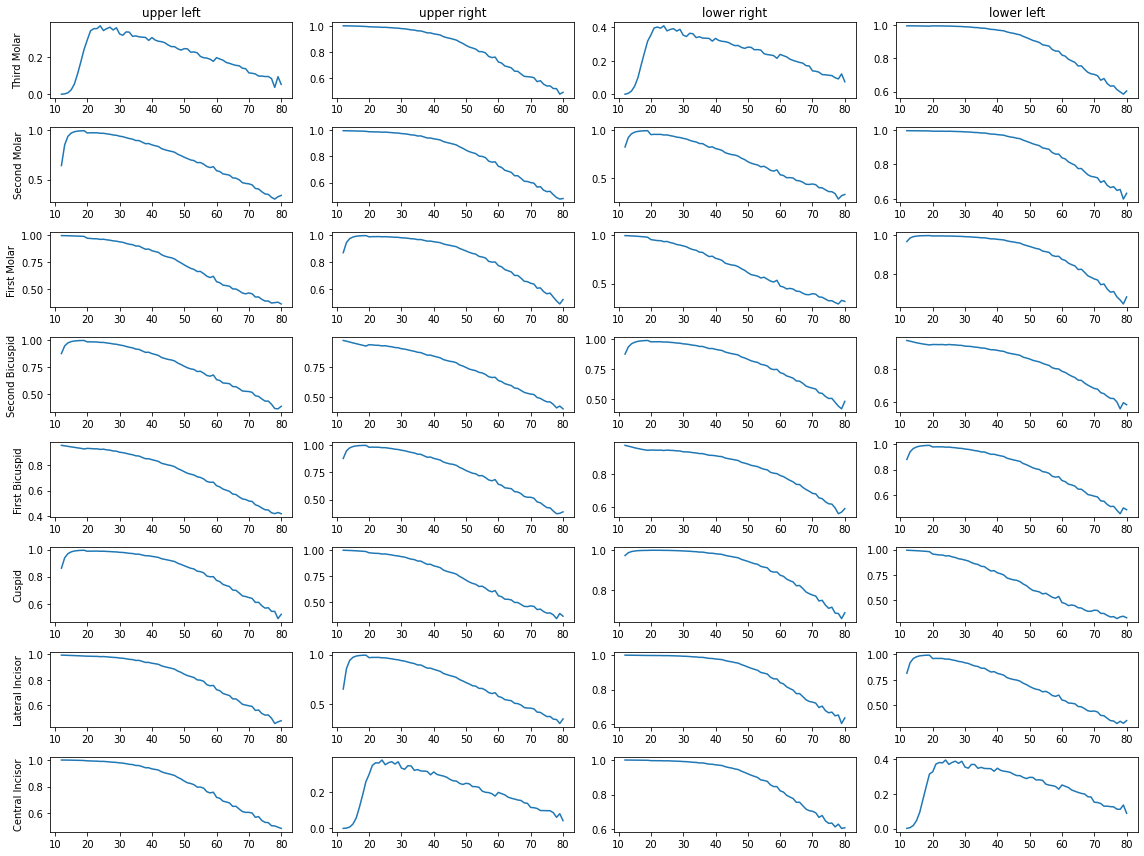

In [20]:
fig = plt.figure()
fig.set_size_inches(16,12)
tooth_name = ['Third Molar','Second Molar','First Molar','Second Bicuspid',
              'First Bicuspid','Cuspid','Lateral Incisor','Central Incisor']
pos_name = ['upper left','upper right','lower right','lower left']
for i in range(len(total_tc)):
    tc = total_tc[i]
    fig.add_subplot(8,4,(i%8)*4+(int(i/8)+1))
    prob = tc+"_probability"
    plt.plot(age_res['age'],age_res[prob])
    if i<8:
        plt.ylabel(tooth_name[i])
    if i%8 == 0:
        plt.title(pos_name[int(i/8)])
fig.tight_layout()

**Figure 1**: predicted probability that a permanent tooth is present varies with age for each tooth with Universal Numbering System

### Question 2

First we prepare the data for this question.

In [21]:
data_qs2 = data_32tc[['Tooth_Count_01','Tooth_Count_01_probability']]
data_qs2.sort_values('Tooth_Count_01_probability',inplace=True)

e:\python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


As we spilt the data into 10 groups uniformly, we calculate the bserved proportion of cases with a permanent tooth and expected proportion, and store them in two lists ```obs_result``` and ```expected_result```.

In [22]:
ten_percent = int(25311/10)
obs_result = []
expected_result = []
for i in range(10):
    if i !=9 :
        data_temp = data_qs2[i*ten_percent:(i+1)*ten_percent]
    else:
        data_temp = data_qs2[i*ten_percent:]
    obs = data_temp['Tooth_Count_01'].sum()/len(data_temp)
    expected = data_temp['Tooth_Count_01_probability'].mean()
    obs_result.append(obs)
    expected_result.append(expected)

And we draw the scatter plot comparing the observed and expected probabilities with a line through the origin with slope 1

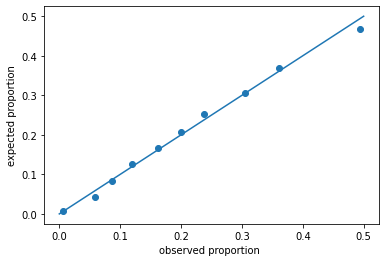

In [23]:
plt.scatter(obs_result,expected_result)
plt.xlabel('observed proportion ')
plt.ylabel('expected proportion')
plt.plot([0,0.5],[0,0.5])
plt.show()

We can see the points in the plot are very close to the line. Although there are some points are not on the line, Only a few points have little distance to the line. Hence we think our model can been said well-calibrated.